In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [3]:
transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

In [4]:
data=pd.read_csv('/home/suraj/Desktop/DeepAgeAnalyzer/train.csv')
class_names0=data['Class'].unique().tolist()
class_names=['YOUNG','MIDDLE','OLD']
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       
data['label']=data['Class'].map(normal_mapping)
dir0='/home/suraj/Desktop/DeepAgeAnalyzer/Train'
data['path']=data['ID'].apply(lambda x:os.path.join(dir0,x))
display(data)

,ID,Class,label,path
0,377.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/377.jpg
1,17814.jpg,YOUNG,0,/home/suraj/Desktop/DeepAgeAnalyzer/Train/1781...
2,21283.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/2128...
3,16496.jpg,YOUNG,0,/home/suraj/Desktop/DeepAgeAnalyzer/Train/1649...
4,4487.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/4487...
...,...,...,...,...
19901,2482.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/2482...
19902,20085.jpg,YOUNG,0,/home/suraj/Desktop/DeepAgeAnalyzer/Train/2008...
19903,19663.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/1966...
19904,10132.jpg,MIDDLE,1,/home/suraj/Desktop/DeepAgeAnalyzer/Train/1013...


In [5]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,1000)
print(path_label[0:3])

[('/home/suraj/Desktop/DeepAgeAnalyzer/Train/21780.jpg', 0), ('/home/suraj/Desktop/DeepAgeAnalyzer/Train/16754.jpg', 1), ('/home/suraj/Desktop/DeepAgeAnalyzer/Train/7422.jpg', 2)]


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [7]:
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        print(dataset_size)
        train_size = int(0.8 * dataset_size) 
        test_size = dataset_size - train_size

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.test_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))

    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.test_dataset is not None:
            return len(self.test_dataset)
        else:
            return 0

    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    #def val_dataloader(self):
        #return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [8]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "/kaggle/input/faces-age-detection-dataset/Train"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        #dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset =  random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [11]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [9]:
if __name__ == '__main__':
    dataset = ImageDataset(path_label)
    dataset.setup() 
    train_dataloader = dataset.train_dataloader()
    test_dataloader = dataset.test_dataloader()
    datamodule = DataModule()
    datamodule.setup()

1000


In [12]:
model = ConvolutionalNetwork()
trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/suraj/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/suraj/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Line

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
# !pip install --upgrade ipywidgets
# !pip install --upgrade notebook
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [13]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(dataloaders=test_loader)

/home/suraj/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/suraj/Desktop/DeepAgeAnalyzer/lightning_logs/version_1/checkpoints/epoch=29-step=600.ckpt
Loaded model weights from the checkpoint at /home/suraj/Desktop/DeepAgeAnalyzer/lightning_logs/version_1/checkpoints/epoch=29-step=600.ckpt
/home/suraj/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.862500011920929
        test_loss           1.1793081760406494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1793081760406494, 'test_acc': 0.862500011920929}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


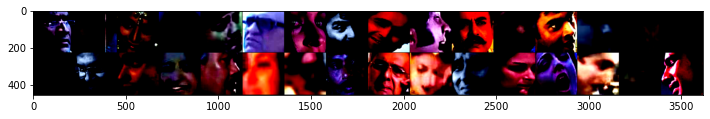

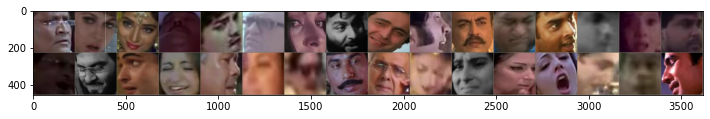

In [14]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [15]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

       YOUNG     0.8929    0.9091    0.9009        55
      MIDDLE     0.9259    0.9146    0.9202        82
         OLD     0.8261    0.8261    0.8261        23

    accuracy                         0.9000       160
   macro avg     0.8816    0.8833    0.8824       160
weighted avg     0.9002    0.9000    0.9001       160

